In [9]:
from transformers import AutoTokenizer, VisualBertModel
import torch

Saving 00000-allegory.jpg to 00000-allegory (4).jpg


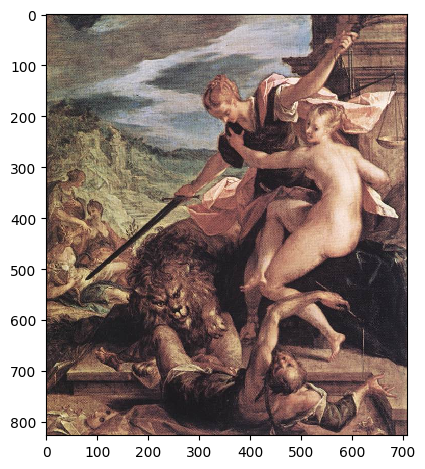

In [15]:
# load image
from skimage.io import imshow
from skimage.io import imread
from google.colab import files
uploaded = files.upload()
image_path = next(iter(uploaded))
image = imshow(image_path)

In [21]:

import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image

# Load pre-trained ResNet model
model = models.resnet50(pretrained=True)
model.eval()

# Preprocess image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Load the image as a PIL Image
image = Image.open(image_path)

image = transform(image).unsqueeze(0)  # Assuming 'image' is a PIL Image

# Pass image through the model
with torch.no_grad():
    visual_embeddings = model(image)

print(visual_embeddings.shape)
text = "The painting, displaying the characteristic Mannerist style of the artist, is also known as The Triumph of Justice"

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 1000])


In [25]:
# get last hidden states
inputs = tokenizer(text, return_tensors="pt")

visual_token_type_ids = torch.ones(visual_embeddings.shape[:-1], dtype=torch.long)
visual_attention_mask = torch.ones(visual_embeddings.shape[:-1], dtype=torch.float)
inputs.update(
    {
        "visual_embeds": visual_embeddings,
        "visual_token_type_ids": visual_token_type_ids,
        "visual_attention_mask": visual_attention_mask,
    }
)

model_fused = VisualBertModel.from_pretrained("uclanlp/visualbert-vqa-coco-pre")
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

outputs = model_fused(**inputs)
last_hidden_state = outputs.last_hidden_state

RuntimeError: Tensors must have same number of dimensions: got 2 and 1

In [28]:
import torch
from transformers import BertTokenizer, VisualBertModel

model = VisualBertModel.from_pretrained("uclanlp/visualbert-vqa-coco-pre")
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")

inputs = tokenizer("What is the man eating?", return_tensors="pt")
# this is a custom function that returns the visual embeddings given the image path
visual_embeds = visual_embeddings

# Determine the shape of visual_embeddings
batch_size, embedding_dim = visual_embeddings.shape

# Create visual_token_type_ids and visual_attention_mask tensors
visual_token_type_ids = torch.ones((batch_size, embedding_dim), dtype=torch.long)
visual_attention_mask = torch.ones((batch_size, embedding_dim), dtype=torch.float)

inputs.update(
    {
        "visual_embeds": visual_embeddings,
        "visual_token_type_ids": visual_token_type_ids,
        "visual_attention_mask": visual_attention_mask,
    }
)
outputs = model(**inputs)
last_hidden_state = outputs.last_hidden_state

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1000 and 2048x768)